In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.semi_supervised import LabelSpreading
from imblearn.over_sampling import SMOTE

rng = np.random.RandomState(0)
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

In [12]:
h = .02
y_30 = np.copy(y)
y_30[rng.rand(len(y)) < 0.3] = -1
y_50 = np.copy(y)
y_50[rng.rand(len(y)) < 0.5] = -1

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
ls30  = (LabelSpreading().fit(X, y_30), y_30)
ls50  = (LabelSpreading().fit(X, y_50), y_50)
ls100 = (LabelSpreading().fit(X, y), y)

In [13]:
rbf_svc = (svm.SVC(kernel = 'rbf', gamma = 0.5).fit(X, y), y)

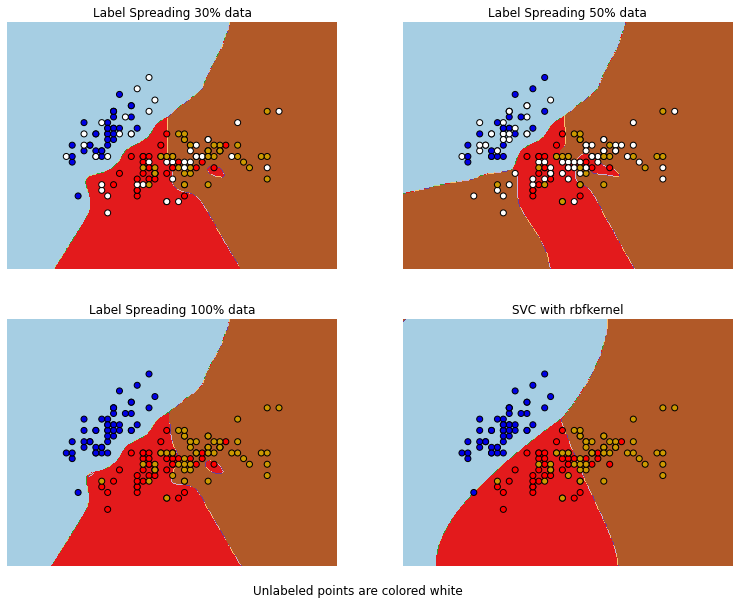

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score

x_min, x_max = X[:, 0].min() -1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() -1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
titles = ['Label Spreading 30% data', 'Label Spreading 50% data', 'Label Spreading 100% data', 'SVC with rbfkernel']
color_map = {-1: (1, 1, 1), 0: (0, 0, .9), 1: (1, 0, 0), 2: (.8, .6, 0)}


plt.figure(figsize = (13, 10))
for i, (clf, y_train) in enumerate((ls30, ls50, ls100, rbf_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].

    plt.subplot(2, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap = plt.cm.Paired)
    plt.axis('off')
    
    # Plot also the training points
    colors = [color_map[y] for y in y_train]
    plt.scatter(X[:, 0], X[:, 1], c = colors, edgecolors = 'black')
    plt.title(titles[i])

plt.suptitle("Unlabeled points are colored white", y=0.1)
plt.show()

In [48]:
from sklearn.datasets import make_classification
from collections import Counter

X, y = make_classification(n_samples = 10000, n_features = 2, n_redundant = 0, 
                           n_clusters_per_class = 1, weights=[0.99], 
                           flip_y = 0, random_state = 1)
counter = Counter(y)

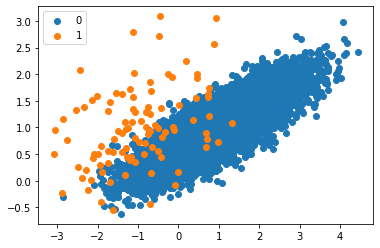

In [49]:
from numpy import where

for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    
plt.legend()
plt.show()

### Oversampling for the Minority Class

Counter({0: 9900, 1: 9900})


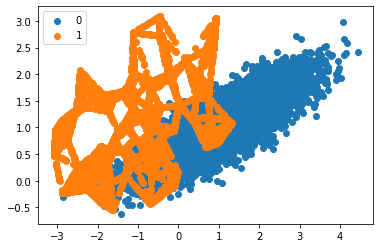

In [59]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

counter = Counter(y)
print(counter)

for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label = str(label))
plt.legend()
plt.show()

### Random Undersampling to the Majority Class

In [68]:
from imblearn.under_sampling import RandomUnderSampler

over  = SMOTE(sampling_strategy = 0.1)

# Oversampling is a half of undersampling
under = RandomUnderSampler(sampling_strategy = 0.5)

X, y = make_classification(n_samples = 10000, n_features = 2, n_redundant = 0, 
                           n_clusters_per_class = 1, weights=[0.99], 
                           flip_y = 0, random_state = 1)
counter = Counter(y)
print(f'Original Class Distribution: \t {counter}')


X, y = under.fit_resample(X, y)          
counter = Counter(y)
print(f'Undersampling Majority Class: \t {counter}')

X, y = make_classification(n_samples = 10000, n_features = 2, n_redundant = 0, 
                           n_clusters_per_class = 1, weights=[0.99], 
                           flip_y = 0, random_state = 1)

X, y = over.fit_resample(X, y)          
counter = Counter(y)
print(f'Oversampling Minority Class: \t {counter}')

Original Class Distribution: 	 Counter({0: 9900, 1: 100})
Undersampling Majority Class: 	 Counter({0: 200, 1: 100})
Oversampling Minority Class: 	 Counter({0: 9900, 1: 990})


### Random Undersampling to the Majority Class

Counter({0: 1980, 1: 990})


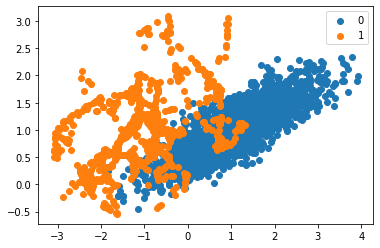

In [70]:
from imblearn.pipeline import Pipeline

over  = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps = steps)

X, y = make_classification(n_samples = 10000, n_features = 2, n_redundant = 0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
X, y = pipeline.fit_resample(X, y)
counter = Counter(y)
print(counter)

for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [89]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

model = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
scores_list = []
for i in range(0, 10):
    scores = cross_val_score(model, X, y, scoring = 'roc_auc', cv=cv, n_jobs = -1)
    print(f'Trial {i} Mean ROC AUC: %.3f' % mean(scores))
    scores_list.append(mean(scores))
mean(scores_list)

Trial 0 Mean ROC AUC: 0.769
Trial 1 Mean ROC AUC: 0.768
Trial 2 Mean ROC AUC: 0.773
Trial 3 Mean ROC AUC: 0.769
Trial 4 Mean ROC AUC: 0.774
Trial 5 Mean ROC AUC: 0.771
Trial 6 Mean ROC AUC: 0.769
Trial 7 Mean ROC AUC: 0.774
Trial 8 Mean ROC AUC: 0.766
Trial 9 Mean ROC AUC: 0.769


0.7704292929292929

# SMOTE for Classification: <code>DecisionTree()</code>

In [101]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits = 15, n_repeats = 3, random_state = 1)
# scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
# print('Mean ROC AUC: %.3f' % mean(scores))

scores_list = []
for i in range(0, 10):
    scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    print(f'Trial {i} Mean ROC AUC: %.3f' % mean(scores))
    scores_list.append(mean(scores))
mean(scores_list)



Trial 0 Mean ROC AUC: 0.823
Trial 1 Mean ROC AUC: 0.827
Trial 2 Mean ROC AUC: 0.810
Trial 3 Mean ROC AUC: 0.815
Trial 4 Mean ROC AUC: 0.824
Trial 5 Mean ROC AUC: 0.824
Trial 6 Mean ROC AUC: 0.814
Trial 7 Mean ROC AUC: 0.819
Trial 8 Mean ROC AUC: 0.807
Trial 9 Mean ROC AUC: 0.819


0.8181945646945648

In [107]:
from imblearn.under_sampling import RandomUnderSampler

X, y = make_classification(n_samples = 10000, n_features = 2, n_redundant = 0, n_clusters_per_class = 1, weights = [0.99], flip_y = 0, random_state = 1)
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
# print('Mean ROC AUC: %.3f' % mean(scores))

scores_list = []
for i in range(0, 10):
    scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    print(f'Trial {i} Mean ROC AUC: %.3f' % mean(scores))
    scores_list.append(mean(scores))
mean(scores_list)

Trial 0 Mean ROC AUC: 0.843
Trial 1 Mean ROC AUC: 0.838
Trial 2 Mean ROC AUC: 0.841
Trial 3 Mean ROC AUC: 0.851
Trial 4 Mean ROC AUC: 0.848
Trial 5 Mean ROC AUC: 0.836
Trial 6 Mean ROC AUC: 0.820
Trial 7 Mean ROC AUC: 0.839
Trial 8 Mean ROC AUC: 0.842
Trial 9 Mean ROC AUC: 0.835


0.839378787878788

In [126]:
X, y = make_classification(n_samples = 10000, n_features = 2, n_redundant = 0, n_clusters_per_class = 1, weights = [0.99], flip_y = 0, random_state = 1)

k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy = 0.1, k_neighbors = k)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    steps = [('over', over), ('under', under), ('model', model)]

    pipeline = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    score = mean(scores)
    print('> k = %d, Mean ROC AUC: %.3f' % (k, score))

> k = 1, Mean ROC AUC: 0.835
> k = 2, Mean ROC AUC: 0.837
> k = 3, Mean ROC AUC: 0.839
> k = 4, Mean ROC AUC: 0.829
> k = 5, Mean ROC AUC: 0.838
> k = 6, Mean ROC AUC: 0.846
> k = 7, Mean ROC AUC: 0.851


In [133]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.svm import SVC
from sklearn import svm

from time import time


================== K = 3 ==================
> k = 3, Mean ROC AUC: 0.946
Fit and predict time: 2.422 seconds


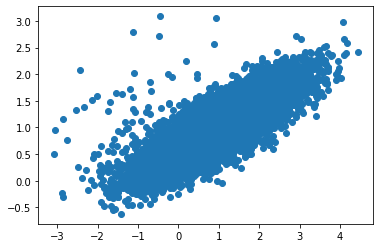

In [138]:
X, y = make_classification(n_samples = 10000, n_features = 2, n_redundant = 0, n_clusters_per_class = 1, weights = [0.99], flip_y = 0, random_state = 1)
plt.scatter(X[:, 0], X[:, 1])

In [141]:
k_values = np.arange(15, 20)
for k in k_values:
    start = time()
    model = KNeighborsClassifier(weights = 'distance', n_neighbors = k)
    over = SMOTE(sampling_strategy = 0.1, k_neighbors = k)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    steps = [('over', over), ('under', under), ('model', model)]

    pipeline = Pipeline(steps = steps)

    cv = RepeatedStratifiedKFold(n_splits = 15, n_repeats = 3, random_state = 1)
    scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    score = mean(scores)
    print(f'================== K = {k} ==================')
    print('> k = %d, Mean ROC AUC: %.3f' % (k, score))
    print(f"Fit and predict time: {np.round(time() - start, 4)} seconds")

================== K = 15 ==================
> k = 15, Mean ROC AUC: 0.936
Fit and predict time: 0.166 seconds
================== K = 16 ==================
> k = 16, Mean ROC AUC: 0.931
Fit and predict time: 0.152 seconds
================== K = 17 ==================
> k = 17, Mean ROC AUC: 0.933
Fit and predict time: 0.171 seconds
================== K = 18 ==================
> k = 18, Mean ROC AUC: 0.940
Fit and predict time: 0.1546 seconds
================== K = 19 ==================
> k = 19, Mean ROC AUC: 0.930
Fit and predict time: 0.1961 seconds


In [142]:
k_values = [5]
for k in k_values:
    start = time()
    model = SVC(kernel = 'rbf', C = 10, gamma = 0.0001)
    over = SMOTE(sampling_strategy = 0.1)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    steps = [('over', over), ('under', under), ('model', model)]

    pipeline = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits = 15, n_repeats = 3, random_state = 1)
    scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    score = mean(scores)
    print(f'================== K = {k} ==================')
    print('> k = %d, Mean ROC AUC: %.3f' % (k, score))
    print(f"Fit and predict time: {np.round(time() - start, 4)} seconds")

================== K = 5 ==================
> k = 5, Mean ROC AUC: 0.947
Fit and predict time: 2.8335 seconds
